# Collect Result

Author: Bingcheng Jin

Date: 2024.1.1

In [12]:
import os
import glob

import matplotlib.pyplot as plt
import numpy as np

from astropy.io import fits
from astropy.table import Table, vstack

In [13]:
band_labels = ['F115W','F150W','F200W','F277W','F356W','F410M','F444W']
nbands = len(band_labels)

In [15]:
sample_base = '../io/sample/'
img_dir_list = glob.glob(sample_base + '*/')
img_dir_list.sort()
img_dir_list

['../io/sample/nircam1/',
 '../io/sample/nircam2/',
 '../io/sample/nircam3/',
 '../io/sample/nircam6/']

In [7]:
tab_row = []
for sample_base_dir in img_dir_list:
    pointing = sample_base_dir.split('/')[-2]
    sample_dir_list = glob.glob(sample_base_dir + '*/')
    sample_dir_list.sort()
    for sample_dir in sample_dir_list:
        id = sample_dir.split('/')[-2] # plz consider naming convention
        output_path = sample_dir + 'output.fits'
        if not os.path.exists(output_path):
            print('Output Not Exist in ',sample_dir)
            continue
        with fits.open(output_path) as hdul:
            tab_info = Table(hdul['FIT_INFO'].data)
            fit_sec = tab_info['FITSECT'][0].split(' ')[0]
            chi2nu = float(tab_info['CHI2NU'].data[0])

            tab_band = Table(hdul['FINAL_BAND'].data)
            xc = list(tab_band['COMP1_XC'])
            xc_e = list(tab_band['COMP1_XC_ERR'])
            yc = list(tab_band['COMP1_YC'])
            yc_e = list(tab_band['COMP1_YC_ERR'])
            mag = list(tab_band['COMP1_MAG'])
            mag_e = list(tab_band['COMP1_MAG_ERR'])
            re = list(tab_band['COMP1_Re'])
            re_e = list(tab_band['COMP1_Re_ERR'])
            n = list(tab_band['COMP1_n'])
            n_e = list(tab_band['COMP1_n_ERR'])
            ar = list(tab_band['COMP1_AR'])
            ar_e = list(tab_band['COMP1_AR_ERR'])
            pa = list(tab_band['COMP1_PA'])
            pa_e = list(tab_band['COMP1_PA_ERR'])

        row = [id, pointing, chi2nu, fit_sec, xc, xc_e, yc, yc_e, mag, mag_e, re, re_e, n, n_e, ar, ar_e, pa, pa_e]
        tab_row.append(row)
tab_result = Table(rows=tab_row, names=['ID','NIRCamPointing', 'CHI2NU', 'FIT_SECTION', 'XC', 'XC_ERR', 'YC', 'YC_ERR', 'MAG', 'MAG_ERR', 'Re', 'Re_ERR', 'n', 'n_ERR', 'AR', 'AR_ERR', 'PA', 'PA_ERR'])

## Check Duplication

In [8]:
unq, count = np.unique(tab_result['ID'], return_counts=True)
dup = unq[count > 1]
if len(dup) == 0:
    print('No Duplicated IDs')
else:
    print('Duplicated rows:')
    dup

No Duplicated IDs


## Compare with auto magnitude from Kron photometry

In [9]:
def read_and_convert(csv_path: str):
    tab_i = Table.read(csv_path, format='ascii.csv')
    if 'comment' in tab_i.colnames:
        tab_i['comment'] = tab_i['comment'].astype(str)
    return tab_i

In [10]:
tab_k1 = read_and_convert('./io/prep/nircam1/kronphot.csv')
tab_k2 = read_and_convert('./io/prep/nircam2/kronphot.csv')
tab_k3 = read_and_convert('./io/prep/nircam3/kronphot.csv')
tab_k6 = read_and_convert('./io/prep/nircam6/kronphot.csv')
tabdict = {'nircam1': tab_k1, 'nircam2': tab_k2, 'nircam3': tab_k3, 'nircam6': tab_k6}

FileNotFoundError: [Errno 2] No such file or directory: './io/prep/nircam1/kronphot.csv'

In [8]:
bandlabel = ['F115W','F150W','F200W','F277W','F356W','F410M','F444W']
k_col = []
for row in tab_result:
    id = row['ID']
    pointing = row['NIRCamPointing']
    tab_k = tabdict[pointing]
    row_k = tab_k[tab_k['ID'] == int(id)][0]
    klist = []
    for i,bandlabel in enumerate(band_labels):
        kflux = row_k[f'KronPhot_{bandlabel}_mag']
        klist.append(kflux)
    k_col.append(np.float32(klist))
tab_result.add_column(k_col, name='KronMag')

In [11]:
tab_result.write('./result_egs_linear.ecsv', overwrite=False)

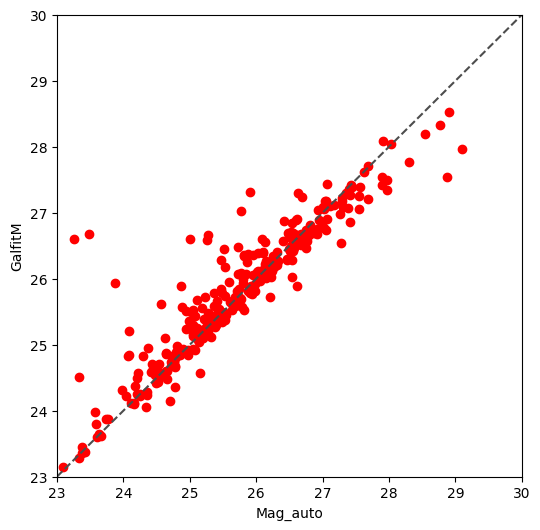

In [10]:
band_num = 5
bandlabel = ['F115W','F150W','F200W','F277W','F356W','F410M','F444W']
fig, ax = plt.subplots(figsize=(6,6))
for row in tab_result:
    kflux, gflux = row['KronMag'][band_num], row['MAG'][band_num]
    ax.plot(kflux, gflux, 'o', color='red')
ax.set_xlim(23, 30)
ax.set_ylim(23, 30)
ax.plot(plt.xlim(), plt.ylim(), ls="--", c='.3')
ax.set_xlabel('Mag_auto')
ax.set_ylabel('GalfitM')
plt.show()

## Collect Multi-Component Result

In [16]:
mcomp_dir = '../multicomp/'
tab_row = []
for sample_base_dir in img_dir_list:
    pointing = sample_base_dir.split('/')[-2]
    sample_dir_list = glob.glob(sample_base_dir + '*/')
    sample_dir_list.sort()
    for sample_dir in sample_dir_list:
        id = sample_dir.split('/')[-2] # plz consider naming convention
        
        if os.path.exists(mcomp_dir + id):
            output_path = mcomp_dir + id + '/' + f'output_multicomp.fits'
            isolate = 0
        else:   
            output_path = sample_dir + 'output.fits'
            isolate = 1
            
        with fits.open(output_path) as hdul:
            tab_info = Table(hdul['FIT_INFO'].data)
            fit_sec = tab_info['FITSECT'][0].split(' ')[0]
            chi2nu = float(tab_info['CHI2NU'].data[0])

            tab_band = Table(hdul['FINAL_BAND'].data)
            xc = list(tab_band['COMP1_XC'])
            xc_e = list(tab_band['COMP1_XC_ERR'])
            yc = list(tab_band['COMP1_YC'])
            yc_e = list(tab_band['COMP1_YC_ERR'])
            mag = list(tab_band['COMP1_MAG'])
            mag_e = list(tab_band['COMP1_MAG_ERR'])
            re = list(tab_band['COMP1_Re'])
            re_e = list(tab_band['COMP1_Re_ERR'])
            n = list(tab_band['COMP1_n'])
            n_e = list(tab_band['COMP1_n_ERR'])
            ar = list(tab_band['COMP1_AR'])
            ar_e = list(tab_band['COMP1_AR_ERR'])
            pa = list(tab_band['COMP1_PA'])
            pa_e = list(tab_band['COMP1_PA_ERR'])
                
        row = [id, pointing, chi2nu, fit_sec, xc, xc_e, yc, yc_e, mag, mag_e, re, re_e, n, n_e, ar, ar_e, pa, pa_e, isolate]
        tab_row.append(row)
tab_result = Table(rows=tab_row, names=['ID','NIRCamPointing', 'CHI2NU', 'FIT_SECTION', 'XC', 'XC_ERR', 'YC', 'YC_ERR', 'MAG', 'MAG_ERR', 'Re', 'Re_ERR', 'n', 'n_ERR', 'AR', 'AR_ERR', 'PA', 'PA_ERR', 'ISOLATE'])

In [19]:
tab_result.write('../result/result_egs_linear_multicomp.ecsv', overwrite=True)

In [17]:
tab_result[tab_result['ISOLATE'] == 1]

ID,NIRCamPointing,CHI2NU,FIT_SECTION,XC,XC_ERR,YC,YC_ERR,MAG,MAG_ERR,Re,Re_ERR,n,n_ERR,AR,AR_ERR,PA,PA_ERR,ISOLATE
str5,str7,float64,str13,float32[7],float32[7],float32[7],float32[7],float32[7],float32[7],float32[7],float32[7],float32[7],float32[7],float32[7],float32[7],float32[7],float32[7],int64
21944,nircam1,1.0932403802871704,"[1:170,1:170]",86.379654 .. 86.39143,0.05537043 .. 0.039350834,86.71709 .. 86.39278,0.075808756 .. 0.032558147,26.153307 .. 23.820753,0.029714104 .. 0.024264654,8.047465 .. 0.04783723,0.15329708 .. 0.0076039373,4.969424 .. 9.999864,0.31976345 .. 0.5628628,0.49579158 .. 0.49579158,0.006852389 .. 0.006852389,21.657022 .. 21.657022,0.7222825 .. 0.7222825,1
21984,nircam1,0.9825385212898254,"[1:110,1:110]",56.3031 .. 56.281147,0.03917844 .. 0.02934326,57.28542 .. 57.227913,0.08756839 .. 0.048027728,26.396751 .. 25.153725,0.026532715 .. 0.01158136,3.47553 .. 4.4762893,0.068354 .. 0.06412105,0.59325707 .. 2.4069023,0.07621419 .. 0.09495122,0.35886306 .. 0.35886306,0.0067830696 .. 0.0067830696,14.582078 .. 14.582078,0.4879029 .. 0.4879029,1
22209,nircam1,1.0561429262161255,"[1:124,1:124]",62.95325 .. 63.51088,0.034330253 .. 0.035480548,63.03482 .. 63.22707,0.03171938 .. 0.033228897,24.841326 .. 24.485563,0.012074506 .. 0.007934561,5.483427 .. 7.6229978,0.081224725 .. 0.07197786,1.0995065 .. 1.2243776,0.03004235 .. 0.027047368,0.35495254 .. 0.35495254,0.0017125348 .. 0.0017125348,46.460022 .. 46.460022,0.19202934 .. 0.19202934,1
22211,nircam1,1.0955009460449219,"[1:124,1:124]",62.981472 .. 62.57388,0.013247755 .. 0.007650526,64.68795 .. 64.01613,0.017904896 .. 0.010082719,24.341331 .. 23.40513,0.007715808 .. 0.0033937292,4.3301554 .. 4.8825536,0.034029003 .. 0.02211005,1.7265797 .. 1.4872766,0.024831532 .. 0.01692775,0.6170259 .. 0.6170259,0.0015471169 .. 0.0015471169,-31.21587 .. -31.21587,0.21927455 .. 0.21927455,1
22267,nircam1,1.0284417867660522,"[1:268,1:268]",133.92168 .. 135.59058,0.6801519 .. 0.020823225,137.09424 .. 133.25626,1.4695069 .. 0.04392387,26.331942 .. 22.559776,0.076759405 .. 0.0038620175,22.354979 .. 14.354978,0.1370159 .. 0.045966286,0.1359764 .. 0.9621807,0.0142802745 .. 0.0064613107,0.36507797 .. 0.36507797,0.00055415335 .. 0.00055415335,-24.729458 .. -24.729458,0.078012295 .. 0.078012295,1
22572,nircam1,1.066408634185791,"[1:202,1:202]",103.304115 .. 101.95497,0.048327286 .. 0.014946701,105.08743 .. 104.61341,0.027447518 .. 0.008906166,24.948687 .. 23.253723,0.012810559 .. 0.0036469812,6.20371 .. 7.139502,0.073323004 .. 0.04024313,1.7965304 .. 1.6347625,0.030008197 .. 0.01628623,0.43214986 .. 0.43214986,0.0013349141 .. 0.0013349141,-65.437004 .. -65.437004,0.12805931 .. 0.12805931,1
22780,nircam1,0.9907200336456299,"[1:136,1:136]",70.161896 .. 70.35994,0.05917276 .. 0.03717539,69.867584 .. 70.56386,0.0754907 .. 0.04511286,25.504835 .. 24.702242,0.020036979 .. 0.010943347,7.093071 .. 7.3054276,0.15149355 .. 0.105241194,1.2401782 .. 1.440747,0.04936406 .. 0.04026243,0.33790362 .. 0.33790362,0.0030596065 .. 0.0030596065,-38.21751 .. -38.21751,0.26400912 .. 0.26400912,1
23225,nircam1,0.8468009233474731,"[1:160,1:160]",81.13881 .. 80.7945,0.07163214 .. 0.024950828,81.17108 .. 81.29455,0.062321264 .. 0.021838568,24.808453 .. 23.484644,0.026977608 .. 0.01234059,15.196567 .. 12.564654,0.58027506 .. 0.27619803,3.914311 .. 3.0733917,0.10521404 .. 0.056900818,0.8111497 .. 0.8111497,0.003929865 .. 0.003929865,-67.45541 .. -67.45541,0.9294771 .. 0.9294771,1
23708,nircam1,1.0087811946868896,"[1:130,1:130]",68.39798 .. 67.84929,0.2664735 .. 0.121774636,66.19556 .. 66.77852,0.1697593 .. 0.084191725,26.103437 .. 25.690247,0.039950695 .. 0.019686654,7.395026 .. 6.6344748,0.22100504 .. 0.15273844,0.8128896 .. 0.8301018,0.07030779 .. 0.05565947,0.60599214 .. 0.60599214,0.008341009 .. 0.008341009,65.88496 .. 65.88496,1.0681102 .. 1.0681102,1
